In [1]:
 # Diffusion on a Latticefrom biocrnpyler import MultiMixtureGraph, Mixture, Component, Mechanism, Species, Compartment, Complex, Reaction
import numpy as np
from biocrnpyler import *

# Introduction

As we know from the other BioCRNpyler examples, BioCRNpyler is a tool developed to compile CRNs. Before the MultiMixtureGraph class was added, the largest abstraction of CRNs that BioCRNpyler could handle was a Mixture. Here, we expand that by creating a MultiMixtureGraph, which describes the connections between multiple mixtures. This is helpful for modeling interactions between different mixtures, such as diffusion or transport. 

In this notebook, we explore the functionality of the MultiMixtureGraph class such that users have a starting point from which to implement their own funcitonalities.  

#### The Role of Compartments

This is important to understand the MultiMixtureGraph as a whole. In the MultiMixtureGraph class, Compartments serve to hold local information about a mixture. Compartments have a name and a dictionary of relationships to describe local information, linking a compartment to other compartments. For example, in Compartment A's relationship dictionary, it could have the key "external" linking it to compartment B, which describes (in the biological/chemical  representation) A being inside of B. 

In the MultiMixtureGraph, each mixtures has a single associated compartment.

# Main Functionality

The functions below do not include the basic getters/setters. 

#### add_mixture: Adding a Mixture
Parameters: Mixture, Compartment = None

This makes the graph aware of a Mixture. The user will input a mixture and the MultiMixtureGraph class will copy it and create it an associated compartment with a unique compartment name (unless a compartment or compartment name respectivley is already provided). This class deals with name collisions by appending unique integers to the end of repeated names. 

#### add_mixtures: Adding multiple Mixtures
Parameters: Mixtures : List of Mixture, Compartment = None: List of Compartment 

This does the same thing as add_mixture, but allows user to add more than one mixture at once. 

#### connect: Connecting two Mixtures that have already been added
Parameters: Compartment name 1 : String , Compartment name 2: String , relationship of 2 to 1: String, relationship of 1 to 2 : String 

The mixtures being connected must be added to the MultiMixtureGraph by one of the two methods above. Connect links these two in the internal representation of the Mixture graph. The relationship parameters specify how the two are locally related to each other, which is information that is integrated into the respective Compartments.

#### combine_multi_mixture_graph

*This is a class method*

Parameters: MultiMixtureGraphs: List of MultiMixtureGraphs, shared: dictionary, new_name: String 

This method combines two MultiMixtureGraphs into one. The list of MultiMixtureGraphs is those that you want to combine. It can be more than 2. "shared" is of the form string -> list of Compartment names, in which each list of Compartment names index matches to the list of MultiMixtureGraphs given in the previous parameter. This dictionary dictates which compartments should be shared when we are combining two MultiMixtureGraphs (e.g. fusing two cells to have the same cytoplasm). The new_name parameter is what the name of the new MultiMixtureGraph will be. 

#### compile_crn

Compiles the CRN. You can set add_passive_diffusion to True based on a passive_diffusion_dict that details the diffusion rate of specific species. You can also add some univ_rxns as a quick way of adding reactions that can apply to the whole MultiMixtureGraph. 

# Wrappers

This class has some additional wrapper functions for ease of use. 

#### Lattice Wrapper (create_diffusion_lattice)
*This is a class method*

Parameters: n: int, diffusion_species : List of species, mmg_name : string

This class creates an simple n x n lattice of mixtures with species diffusing between them.

 ------------

# Examples


 # Diffusion on a Lattice

Here, a 3x3 lattice is constructed with 9 different mixtures placed into a MultiMixtureGraph and connected to their Moore neighbors (N,S,E,W, and diagonals). They all share a substrate (species s) but no reactions were actively defined between them. However, passive diffusion reacitons were created when the CRN was compiled. Note that the passive diffusion rate is set to 0.2 (arbitrarily). 

In [8]:
s = Species("substrate")

mixtures = []
compartment_names= []

mixtures.append(Mixture("m1"))
mixtures.append(Mixture("m2"))
mixtures.append(Mixture("m3"))
mixtures.append(Mixture("m4"))
mixtures.append(Mixture("m5"))
mixtures.append(Mixture("m6"))
mixtures.append(Mixture("m7"))
mixtures.append(Mixture("m8"))
mixtures.append(Mixture("m9"))

mmg = MultiMixtureGraph("mmg")

for mixture in mixtures:
    mixture.add_species(s)
    m, cn, c = mmg.add_mixture(mixture)
    compartment_names.append(cn)

mmg.connect(compartment_names[0], compartment_names[1], "diff1", "diff1")
mmg.connect(compartment_names[0], compartment_names[4], "diff2", "diff2")
mmg.connect(compartment_names[0], compartment_names[3], "diff3", "diff3")
mmg.connect(compartment_names[1], compartment_names[2], "diff4", "diff4")
mmg.connect(compartment_names[1], compartment_names[3], "diff5", "diff5")
mmg.connect(compartment_names[1], compartment_names[5], "diff6", "diff6")
mmg.connect(compartment_names[2], compartment_names[5], "diff7", "diff7")
mmg.connect(compartment_names[2], compartment_names[4], "diff8", "diff8")
mmg.connect(compartment_names[5], compartment_names[8], "diff9", "diff9")
mmg.connect(compartment_names[5], compartment_names[7], "diff10", "diff10")
mmg.connect(compartment_names[4], compartment_names[8], "diff11", "diff11")
mmg.connect(compartment_names[4], compartment_names[7], "diff12", "diff12")
mmg.connect(compartment_names[4], compartment_names[6], "diff13", "diff13")
mmg.connect(compartment_names[3], compartment_names[7], "diff14", "diff14")
mmg.connect(compartment_names[3], compartment_names[6], "diff15", "diff15")

CRN = mmg.compile_crn(df = 0.2) 

# print("CRN STRING REPRESENTATION: \n",CRN, "\n\n")
# print("CRN PRETTY-PRINT REPRESENTATION:\n",
#       CRN.pretty_print(show_rates = True, show_attributes = True, show_materials = True, show_keys = False))


PROBLEM1


ValueError: Your mixtures, mixture map, and compartment maps are not consistent!

To simulate, we plot a representation of the concentrations of s in each mixture. We can see that over time, the mixtures settle to a uniform discribution of concentration, as expected with even diffusion.

In [3]:
timepoints = np.arange(0, 100, 1)
x0_dict = {"substrate_m1_1": 80.}
stochastic = False
results = CRN.simulate_with_bioscrape_via_sbml(timepoints, initial_condition_dict = x0_dict, stochastic = stochastic)

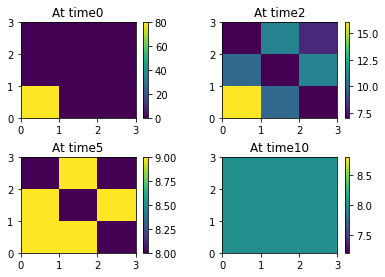

In [5]:
%matplotlib inline
import pylab as plt8u

grids = []
for i in range(4):
    grids.append(np.zeros((3,3)))
grid_vals = [0, 2, 5, 10]

for i in range(3):
    for j in range(3):
        for k in range(len(grids)):
            grid = grids[k]
            grid[i][j] = int(results["substrate_m"+ str(i+j+1)+"_1"][grid_vals[k]])
       

figure, axis = plt.subplots(2, 2)
  
# For Sine Function

grid_c = 0
for i in range(2):
    for j in range(2):
        cb = axis[i, j].pcolormesh(grids[grid_c])
        figure.colorbar(cb, ax=axis[i,j])
        axis[i,j].set_title("At time" + str(grid_vals[grid_c]))
        grid_c += 1
        

plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)
plt.show()


To see this in a different way, observe in the plot below how all concentrations converge to the same level, which is consistent with what happens in passive diffusion. 

In [5]:
timepoints = np.arange(0, 50, .01)
x0_dict = {"substrate_m1_1": 40., "substrate_m2_1": 5., "substrate_m3_1": 0., "substrate_m4_1": 100., 
           "substrate_m5_1": 25.,"substrate_m6_1": 2., "substrate_m7_1": 75.,"substrate_m8_1": 60., 
           "substrate_m9_1": 10.}
stochastic = False
results2 = CRN.simulate_with_bioscrape_via_sbml(timepoints, initial_condition_dict = x0_dict, stochastic = stochastic)

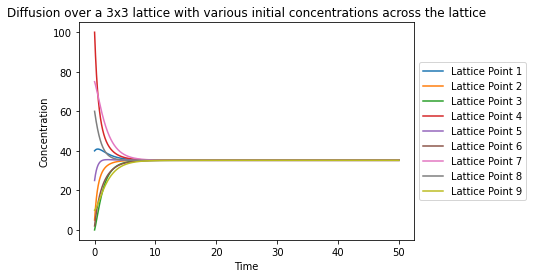

In [6]:
if results2 is not None:
    plt.plot(timepoints, results2["substrate_m1_1"],label = "Lattice Point 1")
    plt.plot(timepoints, results2["substrate_m2_1"],label = "Lattice Point 2")
    plt.plot(timepoints, results2["substrate_m3_1"],label = "Lattice Point 3")
    plt.plot(timepoints, results2["substrate_m4_1"],label = "Lattice Point 4")
    plt.plot(timepoints, results2["substrate_m5_1"],label = "Lattice Point 5")
    plt.plot(timepoints, results2["substrate_m6_1"],label = "Lattice Point 6")
    plt.plot(timepoints, results2["substrate_m7_1"],label = "Lattice Point 7")
    plt.plot(timepoints, results2["substrate_m8_1"],label = "Lattice Point 8")
    plt.plot(timepoints, results2["substrate_m9_1"],label = "Lattice Point 9")
    plt.xlabel("Time")
    plt.ylabel("Concentration")
    plt.title("Diffusion over a 3x3 lattice with various initial concentrations across the lattice")

    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Membrane Transport

Here, we simulate a substrate being transported through a membrane via a protein transporter. This MultiMixtureGraph contains three mixtures: one for an internal environment, one for an external environment, and one for a membrane containing the protein transporter.

The protien-transporter mixture utilizes a membrane-transport component and mechanism. 

This examples also includes the way compartments were utilized before MultiMixtureGraph was created (Compartments were assigned to species) to show how this can be integraded into the new functionality of Compartments. 

Additional species T and V act as "controls" that are not transported across the membrane. 


In [2]:
class MembraneTransport(Mechanism):
    def __init__(self, name, transport_protein, type = "transport_with_protein", **keywords):
        if isinstance(transport_protein, Species):
            self.transport_protein = transport_protein
        else:
            raise ValueError("'transport_protein' must be a Species!")
        Mechanism.__init__(self = self, name = name, mechanism_type = type, **keywords)
        
    def update_species(self, int_species, ext_species):
        species = [int_species, ext_species, self.transport_protein]
        species += [Complex([int_species, self.transport_protein])]
        return species
        
    def update_reactions(self, int_species, ext_species, component, part_id = None):
        kb =(component.get_parameter("kb", part_id = part_id, mechanism  = self)).value
        ku = (component.get_parameter("ku", part_id = part_id, mechanism = self)).value
        kt = (component.get_parameter("kt", part_id = part_id, mechanism = self)).value
        
    
        comp = Complex([int_species, self.transport_protein])
        
        binding_rxn = Reaction.from_massaction(inputs=[int_species, self.transport_protein], outputs=[comp], k_forward=kb, k_reverse=ku)
        transport_rxn = Reaction.from_massaction(inputs=[comp], outputs=[self.transport_protein, ext_species], k_forward=kt)
    
        return [binding_rxn, transport_rxn]
    
    
class MembraneTransportProtein(Component):
    
    def __init__(self, name, int_m, ext_m, transport_prot, **keywords):
        self.internal = self.set_species(int_m, material_type = "molecule")
        self.external = self.set_species(ext_m, material_type = "molecule")
        self.transport_protien = self.set_species(transport_prot, material_type = "protien")
        Component.__init__(self = self, name = name, **keywords)
    
    def update_species(self):
        mech_transport = self.get_mechanism("transport_with_protein")
        return mech_transport.update_species(self.internal, self.external)
    
    def update_reactions(self):
        mech_transport = self.get_mechanism("transport_with_protein")
        return mech_transport.update_reactions(self.internal, self.external, component = self, part_id = self.name)

In [3]:
internal = Compartment("internal")
external = Compartment("external")
s_int = Species("substrate", compartment = internal)
s_ext = Species("substrate", compartment = external)
t = Species("t")
v = Species ("v")

M_int = Mixture("internal_mx")
M_int.add_species(s_int)
M_int.add_species(t)
M_ext = Mixture("external_mx")
M_ext.add_species(s_ext)
M_ext.add_species(v)

transport_protein = Species("transport_prot", material_type = "protein")

params = {"kb": 0.3, "ku": 0.7, "kt": 0.5} # arbitrary

mechanism = MembraneTransport("transport_with_protein", transport_protein) 
transport_molecules =  MembraneTransportProtein("membrane1", s_int, s_ext, transport_protein, parameters = params)
M_memb = Mixture("transport_mixture", components = [transport_molecules], parameters = params, mechanisms = mechanism)


mmg = MultiMixtureGraph("membrane_transport_graph")
m1, cn1, c1 = mmg.add_mixture(M_int, compartment = internal)
m2, cn2, c2 = mmg.add_mixture(M_ext, compartment = external)
m3, cn3, c3 = mmg.add_mixture(M_memb, compartment = "membrane")
mmg.connect(cn1, cn3, "external_membrane", "internal")
mmg.connect(cn2, cn3, "internal_membrane", "exernal")


CRN2 = mmg.compile_crn(add_passive_diffusion = False)

print("CRN STRING REPRESENTATION: \n", CRN2, "\n\n")
print("CRN PRETTY-PRINT REPRESENTATION:\n",
      CRN2.pretty_print(show_rates = True, show_attributes = True, show_materials = True, show_keys = False))


internal_mx
external_mx
transport_mixture
CRN STRING REPRESENTATION: 
 Species = substrate_internal, t_internal, substrate_external, v_external, protein_transport_prot_membrane_1, complex_protein_transport_prot_membrane_1_substrate_internal_membrane_1_, complex_protein_transport_prot_membrane_1_substrate_internal_
Reactions = [
	substrate+protein[transport_prot] <--> complex[protein[transport_prot]:substrate]
	complex[protein[transport_prot]:substrate] --> protein[transport_prot]+substrate
] 


CRN PRETTY-PRINT REPRESENTATION:
 Species(N = 7) = {
v (@ 0),  protein[transport_prot] (@ 0),  t (@ 0),  substrate (@ 0),  substrate (@ 0),  complex[protein[transport_prot]:substrate] (@ 0),  complex[protein[transport_prot]:substrate] (@ 0),  
}

Reactions (2) = [
0. substrate+protein[transport_prot] <--> complex[protein[transport_prot]:substrate]
 Kf=k_forward * substrate_internal * protein_transport_prot_membrane_1
 Kr=k_reverse * complex_protein_transport_prot_membrane_1_substrate_internal_
 

Now, we simulate deterministically. As you can see, the amount of internal substrate decreases as it is transported across the membrane and transformed to external substrate. Levels of T and V stay constant, and the amount of bound + unbound probe stays constant. This is all what we expect. 

In [4]:
timepoints = np.arange(0, 500, .01)
x0_dict = {"substrate_internal": 50., "protein_transport_prot_membrane_1": 1., "t_internal": 15., "v_external": 10., "substrate_external": 0.}
stochastic = False
results3 = CRN2.simulate_with_bioscrape_via_sbml(timepoints, initial_condition_dict = x0_dict, stochastic = stochastic)

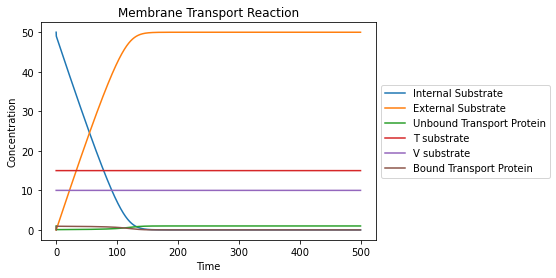

In [5]:
if results3 is not None:
    plt.plot(timepoints, results3["substrate_internal"],label = "Internal Substrate")
    plt.plot(timepoints, results3["substrate_external"],label = "External Substrate")
    plt.plot(timepoints, results3["protein_transport_prot_membrane_1"],label = "Unbound Transport Protein")
    plt.plot(timepoints, results3["t_internal"],label = "T substrate")
    plt.plot(timepoints, results3["v_external"],label = "V substrate")
    plt.plot(timepoints, results3["complex_protein_transport_prot_membrane_1_substrate_internal_"],label = "Bound Transport Protein")
    
    plt.xlabel("Time")
    plt.ylabel("Concentration")
    plt.title("Membrane Transport Reaction")
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))


# Lattice Wrapper

Instead of manually creating a lattice, the user can use the lattice wrapper which automatically creates an n x n diffusion lattice. It can be modified, or compiled right away. As you can see, it allows for the practical creation of many more mixtures in a lattice. For example, below I create a lattice with 100 mixtures.

In [6]:
n = 10
mmg= MultiMixtureGraph("test_lattice_wrapper")
specs = [Species("substrate")]
mmg_lattice = mmg.create_diffusion_lattice(n, specs, "test_lattice_wrapper")

PROBLEM1


ValueError: Your mixtures, mixture map, and compartment maps are not consistent!

In [7]:
CRN3 = mmg_lattice.compile_crn(df = 0.2) 

NameError: name 'mmg_lattice' is not defined

In [7]:
timepoints = np.arange(0, 500, 1)
x0_dict = {"substrate_m1_1": 150.}
stochastic = False
results = CRN3.simulate_with_bioscrape_via_sbml(timepoints, initial_condition_dict = x0_dict, stochastic = stochastic)

NameError: name 'CRN3' is not defined

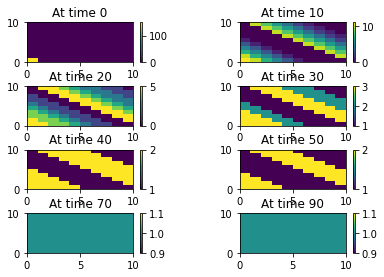

In [14]:
num_plots = 8
grids = []
for i in range(num_plots):
    grids.append(np.zeros((n,n)))
grid_vals = [0, 10, 20, 30, 40, 50, 70, 90]

for i in range(n):
    for j in range(n):
        for k in range(len(grids)):
            grid = grids[k]
            grid[i][j] = int(results["substrate_m" + str(i+j+1)+ "_1"][grid_vals[k]])
       

figure, axis = plt.subplots(int(num_plots/2), 2)
  
# For Sine Function

grid_c = 0
for i in range(int(num_plots/2)):
    for j in range(2):
        cb = axis[i, j].pcolormesh(grids[grid_c])
        figure.colorbar(cb, ax=axis[i,j])
        axis[i,j].set_title("At time " + str(grid_vals[grid_c]))
        grid_c += 1
        

plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=.6, 
                    hspace=.6)
plt.rcParams["figure.figsize"] = (6, 6)
plt.show()

# Combining two MultiMixtureGraph objects

The example is an extremely simple example to show how combining two MultiMixtureGraphs would work. Here, there are two MultiMixtureGraphs with a cytoplasm and internal vesicle. They are combined to share the same cytoplasm, resulting in two vesicles in one cytoplasm

In [15]:

vesicle = Mixture("vesicle")
cytoplasm = Mixture("cytoplasm")

# The first MultiMixtureGraph
mmg1 = MultiMixtureGraph("mmg1")
m1, cn1, c1 = mmg1.add_mixture(vesicle)
m2, cn2, c2 = mmg1.add_mixture(cytoplasm)
mmg1.connect(cn1, cn2, "external", "vesicle")

# The second MultiMixtureGraph
mmg2 = MultiMixtureGraph("mmg2")
m3, cn3, c3 = mmg2.add_mixture(vesicle)
m4, cn4, c4 = mmg2.add_mixture(cytoplasm)
mmg2.connect(cn3, cn4, "external", "vesicle")


# combining 
mmg3 = MultiMixtureGraph.combine_multi_mixture_graph([mmg1, mmg2], shared = {"cytoplasm": [cn2, cn4]}, new_name = "mmg3")
print(mmg3.compartment_mixture_map)

combined_crn = mmg3.compile_crn(mmg3)


{'cytoplasm': Mixture: cytoplasm
 }
Compartment = {cytoplasm_1 }, 'm1_1': Mixture: m1
 }
Compartment = {m1_1 }, 'm2_1': Mixture: m2
 }
Compartment = {m2_1 }, 'm3_1': Mixture: m3
 }
Compartment = {m3_1 }, 'm4_1': Mixture: m4
 }
Compartment = {m4_1 }, 'm5_1': Mixture: m5
 }
Compartment = {m5_1 }, 'm6_1': Mixture: m6
 }
Compartment = {m6_1 }, 'm7_1': Mixture: m7
 }
Compartment = {m7_1 }, 'm8_1': Mixture: m8
 }
Compartment = {m8_1 }, 'm9_1': Mixture: m9
 }
Compartment = {m9_1 }, 'internal': Mixture: internal_mx
 }
Compartment = {internal }, 'external': Mixture: external_mx
 }
Compartment = {external }, 'membrane_1': Mixture: transport_mixture
Components = [
	MembraneTransportProtein: membrane1 ]
Mechanisms = {
	transport_with_protein:transport_with_protein }
Compartment = {membrane_1 }, 'vesicle_1': Mixture: vesicle
 }
Compartment = {vesicle_1 }, 'm1_1_1': Mixture: m1
 }
Compartment = {m1_1 }, 'm2_1_1': Mixture: m2
 }
Compartment = {m2_1 }, 'm3_1_1': Mixture: m3
 }
Compartment = {m3_1 }, '

As we can see, the result is a MultiMixtureGraph with one cytoplasm and two unique vesicles. 

# UNDER CONSTRUCTION: Turing Patterns

Plan for this:

P -> 2P + S
S+ P -> S

s diffuses faster than p 

In [8]:
n = 2
S = Species("S")
P = Species("P")
ds = .5
dp = .3

specs = [S, P]
mmg = MultiMixtureGraph.create_diffusion_lattice(n, specs, "test_lattice_wrapper")
rxn1 = Reaction.from_massaction(inputs=[P], outputs=[S, P, P], k_forward=1, k_reverse=0.01)
rxn2 = Reaction.from_massaction(inputs=[S, P], outputs=[S], k_forward=1, k_reverse=0.01)
# for mixture in mmg.mixtures: 
    

# add reactions
passive_diffusion_dict = {S: ds, P: dp}

crn_turing = mmg.compile_crn(add_passive_diffusion = True, passive_diffusion_dict = passive_diffusion_dict, univ_rxns = [rxn1, rxn2])


ValueError: Your mixtures, mixture map, and compartment maps are not consistent!

In [17]:
print("CRN STRING REPRESENTATION: \n", crn_turing, "\n\n")
print("CRN PRETTY-PRINT REPRESENTATION:\n",
      crn_turing.pretty_print(show_rates = True, show_attributes = True, show_materials = True, show_keys = False))

CRN STRING REPRESENTATION: 
 Species = S_m1_1, P_m1_1, S_m2_1, P_m2_1, S_m3_1, P_m3_1, S_m4_1, P_m4_1, P, S
Reactions = [
	P <--> S+2P
	S+P <--> S
	P <--> S+2P
	S+P <--> S
	P <--> S+2P
	S+P <--> S
	P <--> S+2P
	S+P <--> S
	S <--> S
	P <--> P
	S <--> S
	P <--> P
	S <--> S
	P <--> P
	S <--> S
	P <--> P
	S <--> S
	P <--> P
	S <--> S
	P <--> P
	S <--> S
	P <--> P
	S <--> S
	P <--> P
	P <--> S+2P
	S+P <--> S
] 


CRN PRETTY-PRINT REPRESENTATION:
 Species(N = 10) = {
S (@ 0),  S (@ 0),  S (@ 0),  S (@ 0),  S (@ 0),  P (@ 0),  P (@ 0),  P (@ 0),  P (@ 0),  P (@ 0),  
}

Reactions (26) = [
0. P <--> S+2P
 Kf=k_forward * P
 Kr=k_reverse * S * P^2
  k_forward=1.0
  k_reverse=0.01

1. S+P <--> S
 Kf=k_forward * S * P
 Kr=k_reverse * S
  k_forward=1.0
  k_reverse=0.01

2. P <--> S+2P
 Kf=k_forward * P
 Kr=k_reverse * S * P^2
  k_forward=1.0
  k_reverse=0.01

3. S+P <--> S
 Kf=k_forward * S * P
 Kr=k_reverse * S
  k_forward=1.0
  k_reverse=0.01

4. P <--> S+2P
 Kf=k_forward * P
 Kr=k_reverse * S * 

In [18]:
timepoints = np.arange(0, 10000, 1)
x0_dict = {"S_m_1": 150., "P_m_1": 150.}
stochastic = False
results = crn_turing.simulate_with_bioscrape_via_sbml(timepoints, initial_condition_dict = x0_dict, stochastic = stochastic)


/Users/mohinimisra/opt/anaconda3/lib/python3.9/site-packages/biocrnpyler-1.1.1-py3.9.egg/biocrnpyler/chemical_reaction_network.py:362: UserWarning: Trying to set species that is not in model: S_m_1
/Users/mohinimisra/opt/anaconda3/lib/python3.9/site-packages/biocrnpyler-1.1.1-py3.9.egg/biocrnpyler/chemical_reaction_network.py:362: UserWarning: Trying to set species that is not in model: P_m_1


In [19]:
num_plots = 8
grids = []
for i in range(num_plots):
    grids.append(np.zeros((n,n)))
grid_vals = [0, 1000, 2000, 3000, 6000, 8000, 9000, 9999]

for i in range(n):
    for j in range(n):
        for k in range(len(grids)):
            grid = grids[k]
            grid[i][j] = int(results["P_m_"+ str(i+j+1)][grid_vals[k]])
       

figure, axis = plt.subplots(int(num_plots/2), 2)
  
# For Sine Function

grid_c = 0
for i in range(int(num_plots/2)):
    for j in range(2):
        cb = axis[i, j].pcolormesh(grids[grid_c])
        figure.colorbar(cb, ax=axis[i,j])
        axis[i,j].set_title("At time " + str(grid_vals[grid_c]))
        grid_c += 1
        

plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=.6, 
                    hspace=.6)
plt.rcParams["figure.figsize"] = (6, 6)
plt.show()

KeyError: 'P_m_1'